In [1]:
from google.colab import drive
drive.mount('vggnet')

Mounted at vggnet


# 1. 데이터셋 불러오기

데이터셋은 torchvision 패키지에서 제공하는 STL10 dataset을 이용하겠습니다.

STL10 dataset은 10개의 label을 갖습니다.

In [2]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [3]:
# specify a data path
path2data = '/content/vggnet/MyDrive/data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

Using downloaded and verified file: /content/vggnet/MyDrive/data/stl10_binary.tar.gz
Extracting /content/vggnet/MyDrive/data/stl10_binary.tar.gz to /content/vggnet/MyDrive/data
Files already downloaded and verified


In [4]:
# check train_ds
img, _ = train_ds[1]
print(img.shape)

print(len(train_ds))
print(len(val_ds))

torch.Size([3, 96, 96])
5000
8000


In [5]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


In [6]:
# define the image transformation
# using FiveCrop, normalize, horizontal reflection
train_transformer = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224),
                    transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
])

# test_transformer = transforms.Compose([
#                     transforms.ToTensor(),
#                     transforms.Resize(224),
#                     transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
# ])

# apply transformation
train_ds.transform = train_transformer
val_ds.transform = train_transformer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images indices:  2732


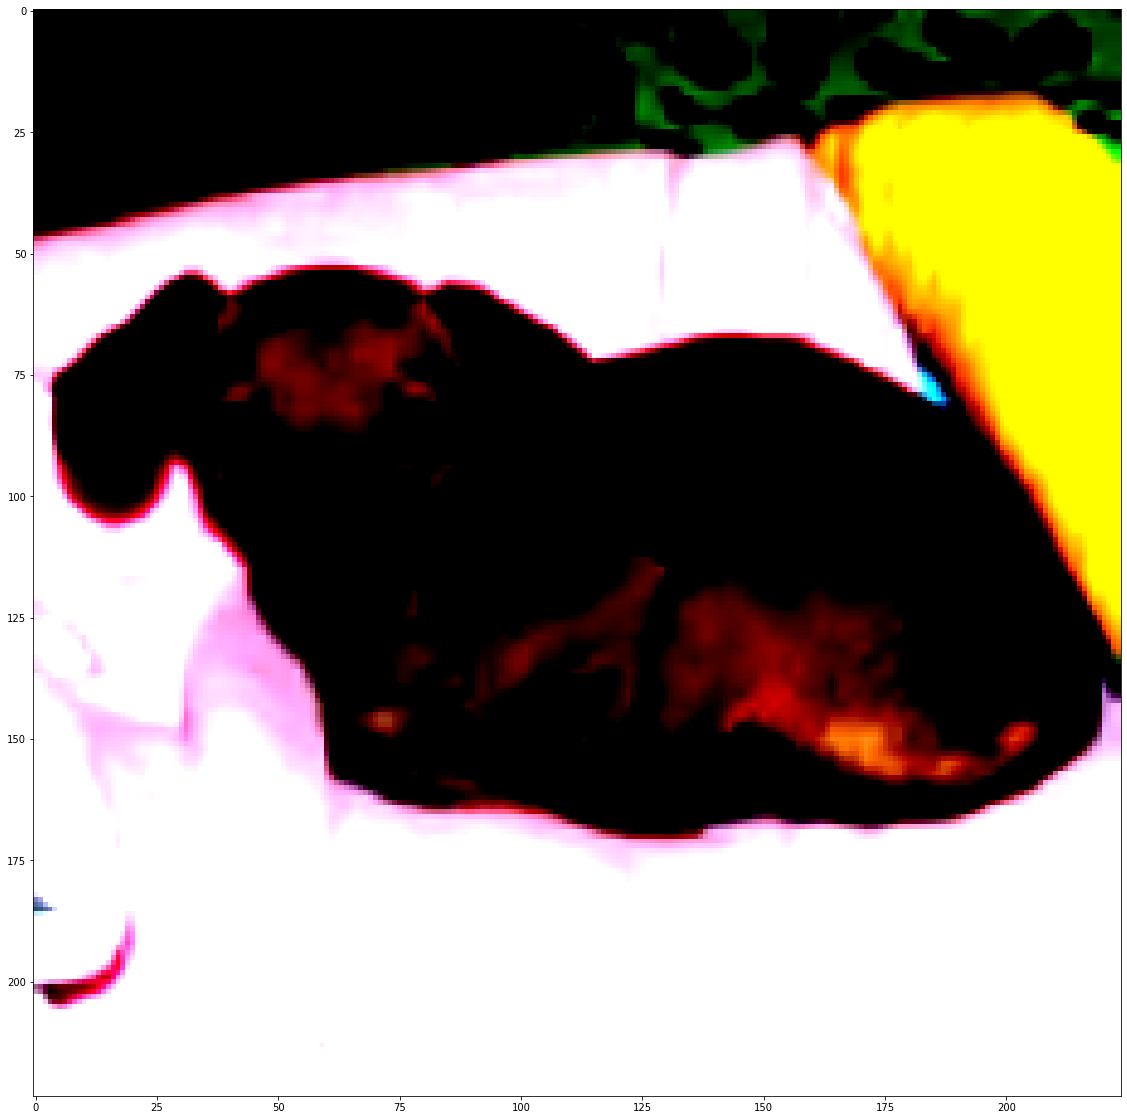

In [7]:
# display transformed sample images

def show(imgs, y=None, color=True):
    # for i, img in enumerate(imgs):
    #     npimg = img.numpy()
    #     npimg_tr = np.transpose(npimg, (1, 2, 0))
    #     plt.subplot(1, imgs.shape[0], i+1)
    #     plt.imshow(npimg_tr)

    npimg = imgs.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)
    
    # plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

np.random.seed(0)
torch.manual_seed(0)

# pick a random sample image
rnd_inds = int(np.random.randint(0, len(train_ds), 1))
img, label = train_ds[rnd_inds]
print('images indices: ', rnd_inds)

plt.figure(figsize=(20, 20))
show(img)

In [8]:
# create dataloader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

# 2. 모델 구축하기

In [9]:
# VGG type dict
# int : output chnnels after conv layer
# 'M' : max pooling layer
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}

In [10]:
# define VGGnet class
class VGGnet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=10, init_weights=True):
        super(VGGnet,self).__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_laters(VGG_types[model])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.fcs(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    # define a function to create conv layer taken the key of VGG_type dict 
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x

                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        
        return nn.Sequential(*layers)

# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# creat VGGnet object
model = VGGnet('VGG16', in_channels=3, num_classes=10, init_weights=True).to(device)
print(model)

cuda
VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3,

In [11]:
# print model summary
summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

# 3. 모델 학습하기

In [12]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=0.001)

# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

# define learning rate scheduler
# from torch.optim.lr_scheduler import CosineAnnealingLR
# lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-5)

from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

current lr=0.001


In [13]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output = model(xb)
        # Five crop : bs, crops, chnnel, h, w
        # making dimmension (bs, c, h, w)
        # bs, ncrops, c, h, w = xb.size()
        # output_=model(xb.view(-1, c, h, w))
        # output = output_.view(bs, ncrops, -1).mean(1)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [14]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # 가중치를 저장할 때, 코랩 GPU 오류나서 생략했습니다.
    # a deep copy of weights for the best performing model
    # best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # check start time
    start_time = time.time()
    # main loop
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # # store weights into a local file
            # torch.save(model.state_dict(), path2weights)
            # print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f, time: %.4f s" %(train_loss,val_loss,100*val_metric, time.time()-start_time))
        print("-"*10) 

    ## load best model weights
    # model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [15]:
# definc the training parameters
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [16]:
# train model
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/9, current lr=0.001
train loss: 4.938084, dev loss: 2.294983, accuracy: 15.04, time: 155.2663 s
----------
Epoch 1/9, current lr=0.001
train loss: 2.236087, dev loss: 2.047815, accuracy: 20.23, time: 310.0073 s
----------
Epoch 2/9, current lr=0.001
train loss: 2.111822, dev loss: 1.977423, accuracy: 20.03, time: 465.4137 s
----------
Epoch 3/9, current lr=0.001
train loss: 2.080703, dev loss: 2.067385, accuracy: 22.25, time: 620.9159 s
----------
Epoch 4/9, current lr=0.001
train loss: 2.107729, dev loss: 1.936401, accuracy: 19.60, time: 777.3536 s
----------
Epoch 5/9, current lr=0.001
train loss: 2.032415, dev loss: 1.893231, accuracy: 22.73, time: 933.1465 s
----------
Epoch 6/9, current lr=0.001
train loss: 2.008678, dev loss: 1.955711, accuracy: 21.38, time: 1089.1959 s
----------
Epoch 7/9, current lr=0.001
train loss: 1.923636, dev loss: 1.818512, accuracy: 22.86, time: 1246.1021 s
----------
Epoch 8/9, current lr=0.001
train loss: 1.883151, dev loss: 1.816732, accuracy

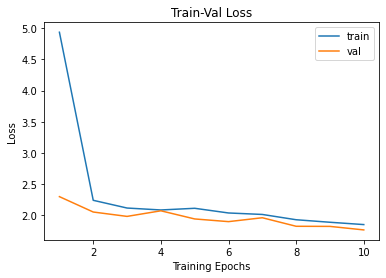

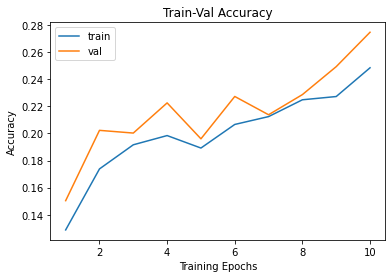

In [17]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()